In [2]:
import os 
import time
import torch 
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt 

from train_mlp_ae import * 
# from trainer import AE_Trainer
from trainer_02 import AE_Trainer
from mlp_ae import MLPVAE, MLP_VQVAE, vae_loss, vqvae_loss



## Plotting Function

In [3]:
import os
import numpy as np
import yaml
import matplotlib.pyplot as plt

def plot_losses(directory_list, legend, title1=None, title2=None, max_loss=None, time_scale=20):
    """
    Plots training and validation losses from a list of directories.
    
    Args:
        directory_list (list): List of paths to experiment directories.
        legend (list): List of strings for the legend labels.
        max_loss (float, optional): If provided, clips loss values > max_loss.
        time_scale (float, optional): The maximum value for the x-axis (e.g., 20).
                                      Data will be scaled to fit 0 to time_scale.
    """
    
    # Initialize two separate figures
    fig_train, ax_train = plt.subplots(figsize=(10, 6))
    fig_val, ax_val = plt.subplots(figsize=(10, 6))
    
    counter = 0
    
    # Iterate through each directory provided
    for directory in directory_list:
        if not os.path.exists(directory):
            print(f"Warning: Directory '{directory}' not found. Skipping.")
            continue

        # Get list of .npy files in the directory
        try:
            files = [f for f in os.listdir(directory) if f.endswith('.npy')]
        except NotADirectoryError:
             print(f"Warning: '{directory}' is not a directory. Skipping.")
             continue

        # Identify train and validation files based on keywords
        train_file = next((f for f in files if 'log_' in f.lower()), None)
        val_file = next((f for f in files if 'val' in f.lower()), None)
        
        print(f"Found training file indicator: {train_file} in {directory}")
        
        # Use the directory name as the label for the plot legend
        label_name = os.path.basename(os.path.normpath(directory))
        current_legend = legend[counter] if counter < len(legend) else label_name

        # --- Process Training Data ---
        if train_file:
            train_path = os.path.join(directory, "losses.npy")
            
            if os.path.exists(train_path):
                train_data = np.load(train_path)
                
                # 1. Handle Clipping
                if max_loss is not None:
                    if train_data.ndim == 1:
                        train_data = np.minimum(train_data, max_loss)
                    elif train_data.ndim == 2:
                        train_data[:, 1] = np.minimum(train_data[:, 1], max_loss)

                # 2. Handle Time Scaling (Attaching X-axis array)
                x_vals = None
                y_vals = None
                
                if train_data.ndim == 1:
                    # Case: 1D Data (Loss only)
                    y_vals = train_data
                    # Explicitly create an array from 0 to time_scale
                    if len(y_vals) > 0:
                        x_vals = np.linspace(0, time_scale, len(y_vals))
                    else:
                        x_vals = np.array([])
                elif train_data.ndim == 2:
                    # Case: 2D Data (Time, Loss)
                    x_raw = train_data[:, 0]
                    y_vals = train_data[:, 1]
                    # Normalize existing time column to 0 - time_scale
                    if len(x_raw) > 0:
                        x_min, x_max = x_raw.min(), x_raw.max()
                        if x_max > x_min:
                            x_vals = (x_raw - x_min) / (x_max - x_min) * time_scale
                        else:
                            x_vals = np.zeros_like(x_raw)
                    else:
                         x_vals = np.array([])

                # Plot with the attached x-scale
                ax_train.plot(x_vals, y_vals, label=current_legend)
            else:
                print(f"Expected 'losses.npy' not found in {directory}")
        else:
            print(f"No training file found in {directory}")

        # --- Process Validation Data ---
        if val_file:
            val_path = os.path.join(directory, val_file)
            val_data = np.load(val_path)
            
            # 1. Handle Clipping
            if max_loss is not None:
                if val_data.ndim == 1:
                    val_data = np.minimum(val_data, max_loss)
                elif val_data.ndim == 2:
                    val_data[:, 1] = np.minimum(val_data[:, 1], max_loss)

            # 2. Handle Time Scaling
            x_vals_val = None
            y_vals_val = None
            
            if val_data.ndim == 1:
                y_vals_val = val_data
                if len(y_vals_val) > 0:
                    x_vals_val = np.linspace(0, time_scale, len(y_vals_val))
                else:
                    x_vals_val = np.array([])
            elif val_data.ndim == 2:
                x_raw = val_data[:, 0]
                y_vals_val = val_data[:, 1]
                if len(x_raw) > 0:
                    x_min, x_max = x_raw.min(), x_raw.max()
                    if x_max > x_min:
                        x_vals_val = (x_raw - x_min) / (x_max - x_min) * time_scale
                    else:
                        x_vals_val = np.zeros_like(x_raw)
                else:
                    x_vals_val = np.array([])

            ax_val.plot(x_vals_val, y_vals_val, label=current_legend)
        else:
            print(f"No validation file found in {directory}")
            
        counter += 1

    # --- Formatting Training Plot ---
    ax_train.set_title("Training Losses Comparison")
    ax_train.set_xlabel(f"Scaled Time (0-{time_scale})")
    ax_train.set_ylabel("Loss")
    if max_loss:
        title = title1 + f"(Clipped at {max_loss})"
        ax_train.set_title(title)
    
    # Increased legend size here
    ax_train.legend(fontsize=16)
    ax_train.grid(True, alpha=0.3)

    # --- Formatting Validation Plot ---
    ax_val.set_title("Validation Losses Comparison")
    ax_val.set_xlabel(f"Scaled Time (0-{time_scale})")
    ax_val.set_ylabel("Loss")
    if max_loss:
        title = title2 + f"(Clipped at {max_loss})"
        ax_val.set_title(title)
    
    # Increased legend size here
    ax_val.legend(fontsize=16)
    ax_val.grid(True, alpha=0.3)

    plt.show()

# MLP AE Hyperparameter Sweep

### Learning Rate Sweep


In [3]:
src_dir = "/extra_storage/three_piece_assembly_latent_actions/buf.pkl"
n_test = 2 
n_val = 10
ac_chunk = 30
obs_dim = [11, 1]
ac_dim = [30, 10]
batch_size = 50
action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val, 
                                            mode="train",
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
val_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="val", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
test_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="test", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim) 

train_loader = DataLoader(action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10)
val_loader = DataLoader(val_action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10) 
test_loader = DataLoader(test_action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10) 

200
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
Mode: train, Index list length: 188


100%|██████████| 188/188 [00:01<00:00, 148.51it/s]


200
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
Mode: val, Index list length: 10


100%|██████████| 10/10 [00:00<00:00, 50.96it/s]


200
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
Mode: test, Index list length: 2


100%|██████████| 2/2 [00:00<00:00, 190.82it/s]


In [5]:
model_type = "MLPVAE"
obs_dim = [9, 1]
ac_dim = [30, 10]
latent_dim = 60
hidden = [300, 300, 300, 300]
model = MLPVAE(obs_dim, ac_dim, latent_dim, hidden)
loss_fn = vae_loss
save_dir = "lr_sweep"
optim_params = {"log_freq": 100,
                "save_freq": 1000,
                "epochs": 20}

learning_rates = [0.1, 0.01]
for lr in learning_rates:
    optim_params["lr"] = lr
    trainer = AE_Trainer(model, 
                         loss_fn, 
                         "cuda:0", 
                         optim_params, 
                         f"lr_sweep_{lr}")
    trainer.train_loop(train_loader, val_loader, 1000)


Architecture of the model: 
 ModuleList(
  (0): Linear(in_features=309, out_features=300, bias=True)
  (1-2): 2 x ResidualBlock(
    (block): ModuleList(
      (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
      (2): GELU(approximate='none')
    )
    (in_proj): Linear(in_features=300, out_features=300, bias=True)
  )
  (3): Linear(in_features=300, out_features=60, bias=True)
)
Architecture of the model: 
 ModuleList(
  (0): Linear(in_features=69, out_features=300, bias=True)
  (1-3): 3 x ResidualBlock(
    (block): ModuleList(
      (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
      (2): GELU(approximate='none')
    )
    (in_proj): Linear(in_features=300, out_features=300, bias=True)
  )
  (4): Linear(in_features=300, out_features=309, bias=True)
)
{'log_freq': 100, 'save_freq': 1000, 'epochs': 20, 'lr': 0.1}


Starting training for 20 epochs, 1000 steps per epoch.
Step 100 | Logged Loss: 3949194002.32196
Step 200 | Logged Loss: 3371079.53531
Step 300 | Logged Loss: 1026720.38297
Step 400 | Logged Loss: 1162960.72375
Step 500 | Logged Loss: 812674.40187
Step 600 | Logged Loss: 687694.91094
Step 700 | Logged Loss: 787432.40109
Step 800 | Logged Loss: 671603.30969
Step 900 | Logged Loss: 717664.75344
Step 1000 | Logged Loss: 695822.88078
Step 1000 | Val Loss: 1281466.85846 | Saving checkpoint...
End of Epoch 0 | Avg Epoch Loss: 395912765.56218
Step 1100 | Logged Loss: 610635.20578
Step 1200 | Logged Loss: 731363.68594
Step 1300 | Logged Loss: 561632.11328
Step 1400 | Logged Loss: 680454.99797
Step 1500 | Logged Loss: 706942.86938
Step 1600 | Logged Loss: 545392.08844
Step 1700 | Logged Loss: 652940.02797
Step 1800 | Logged Loss: 709568.70453
Step 1900 | Logged Loss: 532150.77641
Step 2000 | Logged Loss: 663293.66328
Step 2000 | Val Loss: 723937.10018 | Saving checkpoint...
End of Epoch 1 | Avg 

KeyboardInterrupt: 

Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/lr_sweep_0.1
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/lr_sweep_0.01
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/lr_sweep_0.001
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/lr_sweep_0.0001
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/lr_sweep_1e-05


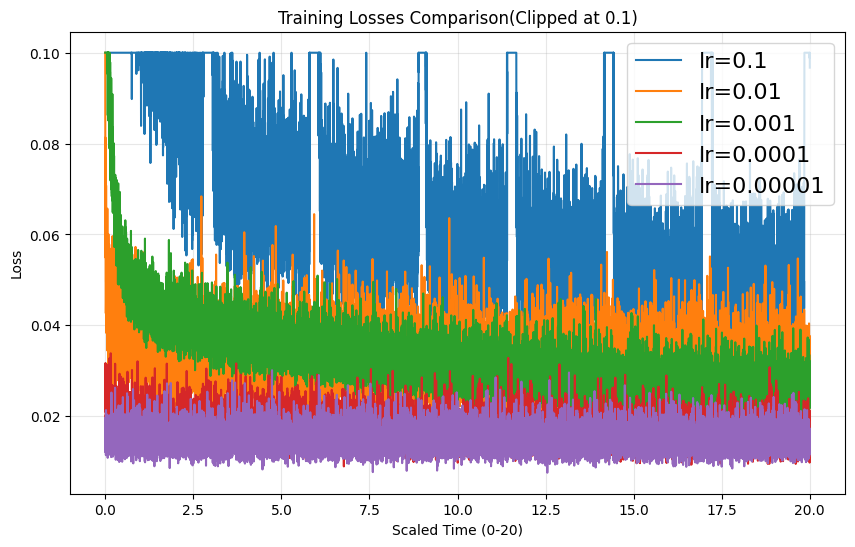

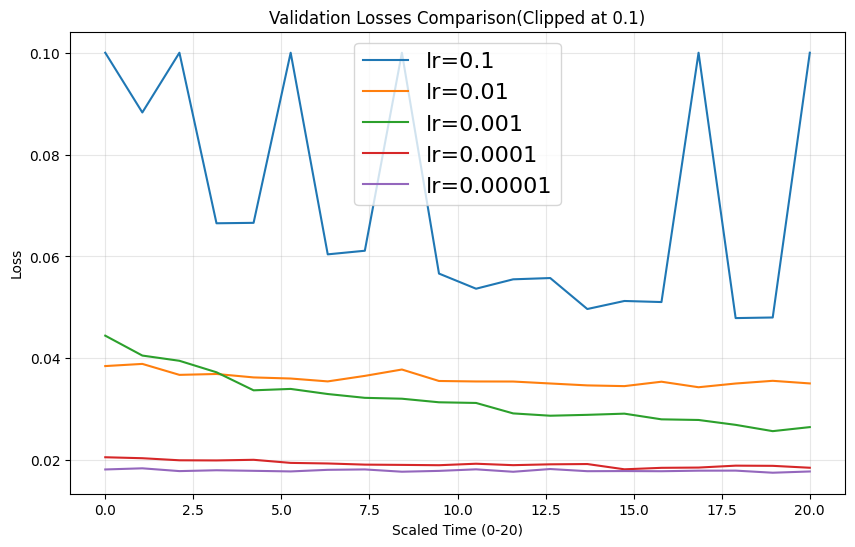

In [45]:
directories_to_plot = [
    '/home/blank/cs282_project/latent_actions/lr_sweep_0.1',
    '/home/blank/cs282_project/latent_actions/lr_sweep_0.01',
    '/home/blank/cs282_project/latent_actions/lr_sweep_0.001', 
    '/home/blank/cs282_project/latent_actions/lr_sweep_0.0001',
    '/home/blank/cs282_project/latent_actions/lr_sweep_1e-05' 
    ]
plot_losses(directories_to_plot, ["lr=0.1","lr=0.01", "lr=0.001", "lr=0.0001", "lr=0.00001"], "Training Losses Comparison",
            "Validation Losses Comparison", max_loss = 0.1)


### Batch Size Tuning


In [ ]:
src_dir = "/extra_storage/three_piece_assembly_latent_actions/buf.pkl"
n_test = 2 
n_val = 10
ac_chunk = 30
obs_dim = [9, 1]
ac_dim = [30, 10]
batch_size = 50
action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val, 
                                            mode="train",
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
val_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="val", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
test_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="test", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim) 

model_type = "MLPVAE"
obs_dim = [9, 1]
ac_dim = [30, 10]
latent_dim = 60
hidden = [300, 300, 300, 300]
model = MLPVAE(obs_dim, ac_dim, latent_dim, hidden)
loss_fn = vae_loss
save_dir = "lr_sweep"
optim_params = {"log_freq": 100,
                "save_freq": 1000,
                "epochs": 20,
                "lr": 0.001}


    

batch_sizes = [10, 20, 50, 100, 150]

for size in batch_sizes:
    train_loader = DataLoader(action_dataset, 
                                    batch_size = batch_size, 
                                    shuffle = True, 
                                    num_workers=10)
    val_loader = DataLoader(val_action_dataset, 
                                    batch_size = batch_size, 
                                    shuffle = True, 
                                    num_workers=10) 
    test_loader = DataLoader(test_action_dataset, 
                                    batch_size = batch_size, 
                                    shuffle = True, 
                                    num_workers=10) 
    trainer = AE_Trainer(model, 
                         loss_fn, 
                         "cuda:0", 
                         optim_params, 
                         f"batch_size_sweep_{size}")
    trainer.train_loop(train_loader, val_loader, 1000)

200
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
Mode: train, Index list length: 188


100%|██████████| 188/188 [00:01<00:00, 132.33it/s]


200
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
Mode: val, Index list length: 10


100%|██████████| 10/10 [00:00<00:00, 192.23it/s]


200
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
Mode: test, Index list length: 2


100%|██████████| 2/2 [00:00<00:00, 193.92it/s]


Architecture of the model: 
 ModuleList(
  (0): Linear(in_features=309, out_features=300, bias=True)
  (1-2): 2 x ResidualBlock(
    (block): ModuleList(
      (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
      (2): GELU(approximate='none')
    )
    (in_proj): Linear(in_features=300, out_features=300, bias=True)
  )
  (3): Linear(in_features=300, out_features=60, bias=True)
)
Architecture of the model: 
 ModuleList(
  (0): Linear(in_features=69, out_features=300, bias=True)
  (1-3): 3 x ResidualBlock(
    (block): ModuleList(
      (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
      (2): GELU(approximate='none')
    )
    (in_proj): Linear(in_features=300, out_features=300, bias=True)
  )
  (4): Linear(in_features=300, out_features=309, bias=True)
)
{'log_freq': 100, 'save_freq': 1000, 'epochs': 20, 'lr': 0.001}
Starting training fo

Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/batch_size_sweep_10
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/batch_size_sweep_20
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/batch_size_sweep_50
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/batch_size_sweep_100
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/batch_size_sweep_150


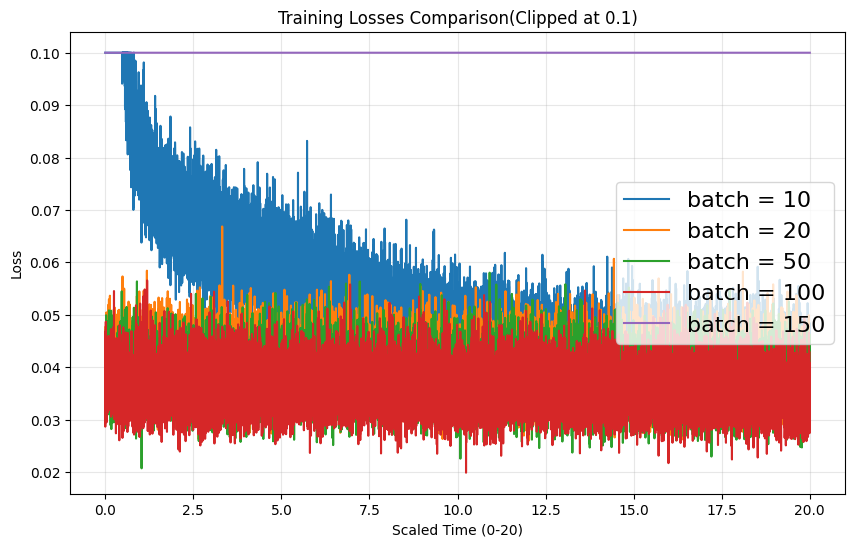

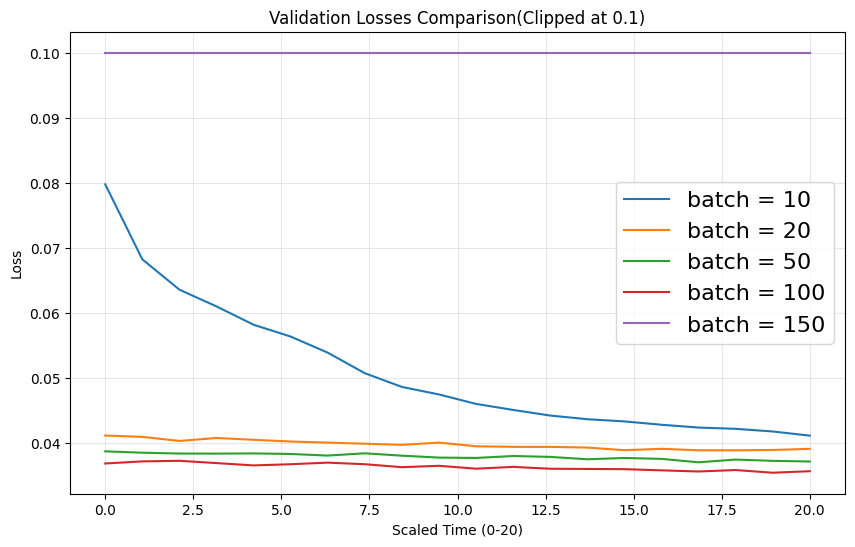

In [46]:
directories_to_plot = [
    '/home/blank/cs282_project/latent_actions/batch_size_sweep_10', 
    '/home/blank/cs282_project/latent_actions/batch_size_sweep_20',
    '/home/blank/cs282_project/latent_actions/batch_size_sweep_50',
    '/home/blank/cs282_project/latent_actions/batch_size_sweep_100',
    '/home/blank/cs282_project/latent_actions/batch_size_sweep_150' 
    ]
plot_losses(directories_to_plot, ["batch = 10", "batch = 20", "batch = 50", "batch = 100","batch = 150" ], "Training Losses Comparison",
            "Validation Losses Comparison", max_loss = 0.1)

## Architectural Sweep

In [2]:
src_dir = "/extra_storage/three_piece_assembly_latent_actions/buf.pkl"
n_test = 2 
n_val = 10
ac_chunk = 30
obs_dim = [9, 1]
ac_dim = [30, 10]
batch_size = 50
action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val, 
                                            mode="train",
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
val_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="val", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
test_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="test", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim) 

train_loader = DataLoader(action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10)
val_loader = DataLoader(val_action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10) 
test_loader = DataLoader(test_action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10) 

200
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
Mode: train, Index list length: 188


100%|██████████| 188/188 [00:01<00:00, 139.24it/s]


200
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
Mode: val, Index list length: 10


100%|██████████| 10/10 [00:00<00:00, 187.02it/s]


200
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
Mode: test, Index list length: 2


100%|██████████| 2/2 [00:00<00:00, 181.45it/s]


In [5]:
model_type = "MLPVAE"
obs_dim = [9, 1]
ac_dim = [30, 10]
latent_dim = 60
hiddens = [[[300, 300, 300, 300], 75],[[300, 300, 300, 300], 150],[[500, 500, 500, 500], 75],[[500, 500, 500, 500], 150],[[150, 150, 150, 150], 75],[[150, 150, 150, 150], 150]]

loss_fn = vae_loss
save_dir = "lr_sweep"
optim_params = {"log_freq": 100,
                "save_freq": 1000,
                "epochs": 20,
                "lr": 0.002}

for i,hidden in enumerate(hiddens):

    model = MLPVAE(obs_dim, ac_dim, hidden[1], hidden[0])
    trainer = AE_Trainer(model, 
                         loss_fn, 
                         "cuda:0", 
                         optim_params, 
                         f"arch_sweep_{i}")
    trainer.train_loop(train_loader, val_loader, 1000)
    

Architecture of the model: 
 ModuleList(
  (0): Linear(in_features=309, out_features=300, bias=True)
  (1-3): 3 x ResidualBlock(
    (block): ModuleList(
      (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
      (2): GELU(approximate='none')
    )
    (in_proj): Linear(in_features=300, out_features=300, bias=True)
  )
  (4): Linear(in_features=300, out_features=75, bias=True)
)
Architecture of the model: 
 ModuleList(
  (0): Linear(in_features=84, out_features=300, bias=True)
  (1-3): 3 x ResidualBlock(
    (block): ModuleList(
      (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
      (2): GELU(approximate='none')
    )
    (in_proj): Linear(in_features=300, out_features=300, bias=True)
  )
  (4): Linear(in_features=300, out_features=309, bias=True)
)
{'log_freq': 100, 'save_freq': 1000, 'epochs': 20, 'lr': 0.002}
Starting training fo

Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/arch_sweep_0
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/arch_sweep_1
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/arch_sweep_2
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/arch_sweep_3
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/arch_sweep_4
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/arch_sweep_5


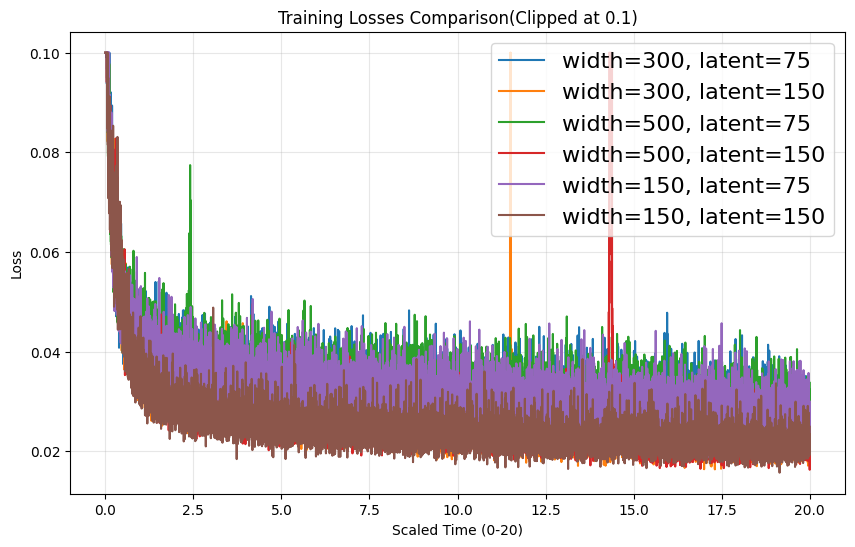

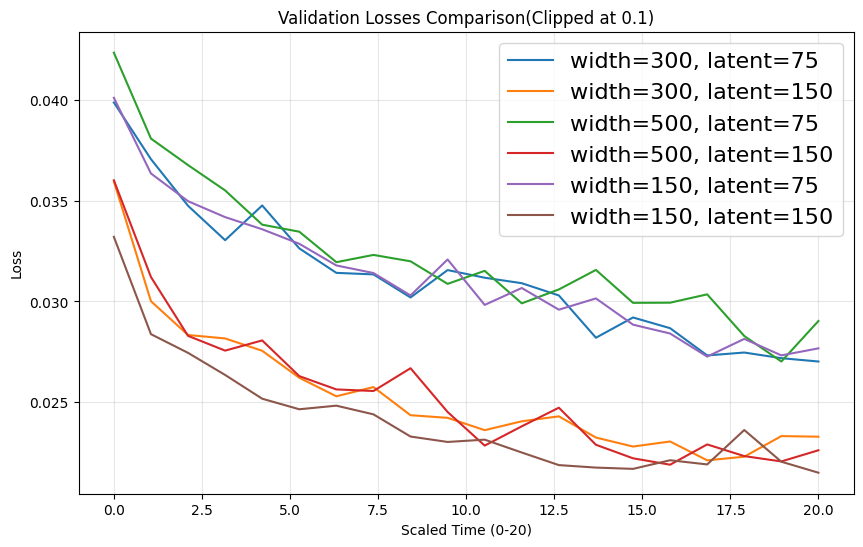

In [8]:
directories_to_plot = [
    '/home/blank/cs282_project/latent_actions/arch_sweep_0', 
    '/home/blank/cs282_project/latent_actions/arch_sweep_1',
    '/home/blank/cs282_project/latent_actions/arch_sweep_2',
    '/home/blank/cs282_project/latent_actions/arch_sweep_3',
    '/home/blank/cs282_project/latent_actions/arch_sweep_4',
    '/home/blank/cs282_project/latent_actions/arch_sweep_5' 
    ]
plot_losses(directories_to_plot, ["width=300, latent=75", "width=300, latent=150", "width=500, latent=75", "width=500, latent=150","width=150, latent=75", "width=150, latent=150" ], "Training Losses Comparison",
            "Validation Losses Comparison", max_loss = 0.1)

In [4]:
src_dir = "/extra_storage/three_piece_assembly_latent_actions/buf.pkl"
n_test = 2 
n_val = 10
ac_chunk = 30
obs_dim = [9, 1]
ac_dim = [30, 10]
batch_size = 50
action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val, 
                                            mode="train",
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
val_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="val", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
test_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="test", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim) 

train_loader = DataLoader(action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10)
val_loader = DataLoader(val_action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10) 
test_loader = DataLoader(test_action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10) 

Mode: train, Index list length: 188


100%|██████████| 188/188 [00:01<00:00, 150.94it/s]


Mode: val, Index list length: 10


100%|██████████| 10/10 [00:00<00:00, 212.25it/s]


Mode: test, Index list length: 2


100%|██████████| 2/2 [00:00<00:00, 196.00it/s]


In [7]:

model_type = "MLPVAE"
obs_dim = [9, 1]
ac_dim = [30, 10]
latent_dim = 75
hidden = [300, 300, 300, 300]

loss_fn = vae_loss
save_dir = "lr_sweep"
optim_params = {"log_freq": 100,
                "save_freq": 1000,
                "epochs": 50,
                "lr": 0.002}
betas = [0.1, 0.2, 0.4 , 0.6, 0.7, 0.8, 0.9]
for i,beta in enumerate(betas):

    model = MLPVAE(obs_dim, ac_dim, latent_dim, hidden)
    trainer = AE_Trainer(model, 
                         loss_fn, 
                         "cuda:0", 
                         optim_params, 
                         f"beta_sweep_{i}",
                         "VAE", dist_reg = beta)
    trainer.train_loop(train_loader, val_loader, 1000)

Architecture of the model: 
 ModuleList(
  (0): Linear(in_features=309, out_features=300, bias=True)
  (1-3): 3 x ResidualBlock(
    (block): ModuleList(
      (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
      (2): GELU(approximate='none')
    )
    (in_proj): Linear(in_features=300, out_features=300, bias=True)
  )
  (4): Linear(in_features=300, out_features=75, bias=True)
)
Architecture of the model: 
 ModuleList(
  (0): Linear(in_features=84, out_features=300, bias=True)
  (1-3): 3 x ResidualBlock(
    (block): ModuleList(
      (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
      (2): GELU(approximate='none')
    )
    (in_proj): Linear(in_features=300, out_features=300, bias=True)
  )
  (4): Linear(in_features=300, out_features=309, bias=True)
)
{'log_freq': 100, 'save_freq': 1000, 'epochs': 50, 'lr': 0.002}
Starting training fo

Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/beta_sweep_0
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/beta_sweep_1
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/beta_sweep_2
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/beta_sweep_3
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/beta_sweep_4
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/beta_sweep_5
Found training file indicator: log_losses.npy in /home/blank/cs282_project/latent_actions/beta_sweep_6


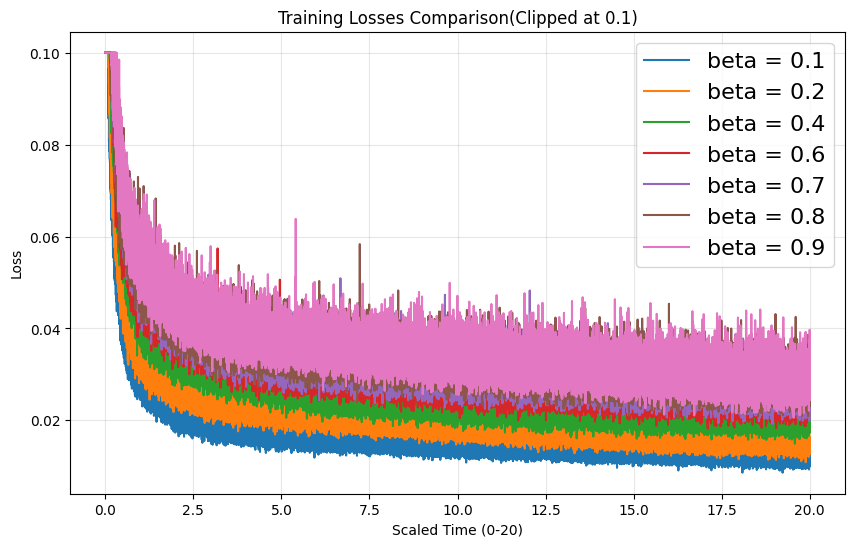

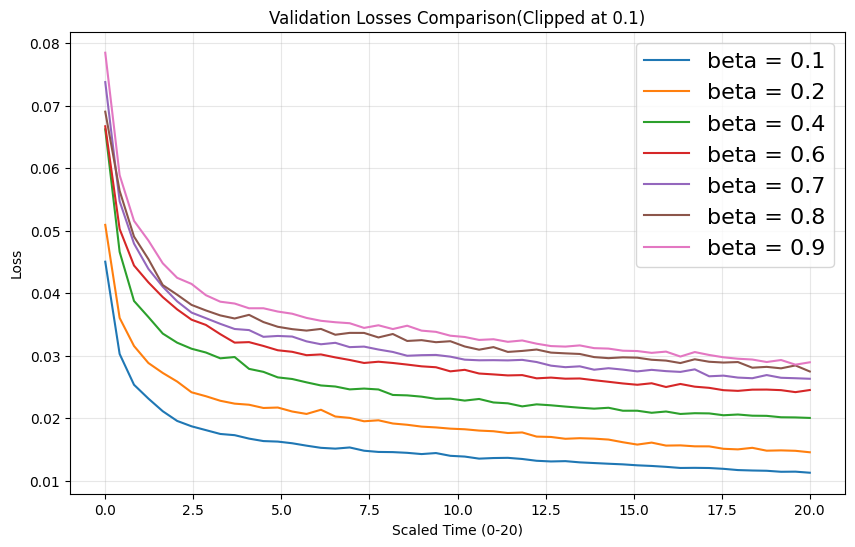

In [10]:
directories_to_plot = [
    '/home/blank/cs282_project/latent_actions/beta_sweep_0', 
    '/home/blank/cs282_project/latent_actions/beta_sweep_1',
    '/home/blank/cs282_project/latent_actions/beta_sweep_2',
    '/home/blank/cs282_project/latent_actions/beta_sweep_3',
    '/home/blank/cs282_project/latent_actions/beta_sweep_4',
    '/home/blank/cs282_project/latent_actions/beta_sweep_5',
    '/home/blank/cs282_project/latent_actions/beta_sweep_6' 
    ]
betas = [0.1, 0.2, 0.4 , 0.6, 0.7, 0.8, 0.9]
plot_losses(directories_to_plot, [f"beta = {i}" for i in betas], "Training Losses Comparison",
            "Validation Losses Comparison", max_loss = 0.1)

In [16]:
from train_mlp_ae import get_test_accuracy
directories_to_plot = [
    '/home/blank/cs282_project/latent_actions/beta_sweep_0', 
    '/home/blank/cs282_project/latent_actions/beta_sweep_1',
    '/home/blank/cs282_project/latent_actions/beta_sweep_2',
    '/home/blank/cs282_project/latent_actions/beta_sweep_3',
    '/home/blank/cs282_project/latent_actions/beta_sweep_4',
    '/home/blank/cs282_project/latent_actions/beta_sweep_5',
    '/home/blank/cs282_project/latent_actions/beta_sweep_6' 
    ]
test_accuracies = []
for i in directories_to_plot: 
    obs_dim = [9, 1]
    ac_dim = [30, 10]
    latent_dim = 75
    hidden = [300, 300, 300, 300]

    model = MLPVAE(obs_dim, ac_dim, latent_dim, hidden)
    state_dict = torch.load(os.path.join(i, "checkpoint.pth"))
    model.load_state_dict(state_dict["model_state_dict"])
    model.eval().cuda()
    criterion = nn.MSELoss()
    test_accuracies.append(get_test_accuracy(model, val_action_dataset, model_type="VAE" ))
print(test_accuracies)

Architecture of the model: 
 ModuleList(
  (0): Linear(in_features=309, out_features=300, bias=True)
  (1-3): 3 x ResidualBlock(
    (block): ModuleList(
      (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
      (2): GELU(approximate='none')
    )
    (in_proj): Linear(in_features=300, out_features=300, bias=True)
  )
  (4): Linear(in_features=300, out_features=75, bias=True)
)
Architecture of the model: 
 ModuleList(
  (0): Linear(in_features=84, out_features=300, bias=True)
  (1-3): 3 x ResidualBlock(
    (block): ModuleList(
      (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
      (2): GELU(approximate='none')
    )
    (in_proj): Linear(in_features=300, out_features=300, bias=True)
  )
  (4): Linear(in_features=300, out_features=309, bias=True)
)


Evaluation complete. Average Reconstruction Loss (MSE): 0.0058 (Std Dev: 0.0016)
Architecture of the model: 
 ModuleList(
  (0): Linear(in_features=309, out_features=300, bias=True)
  (1-3): 3 x ResidualBlock(
    (block): ModuleList(
      (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
      (2): GELU(approximate='none')
    )
    (in_proj): Linear(in_features=300, out_features=300, bias=True)
  )
  (4): Linear(in_features=300, out_features=75, bias=True)
)
Architecture of the model: 
 ModuleList(
  (0): Linear(in_features=84, out_features=300, bias=True)
  (1-3): 3 x ResidualBlock(
    (block): ModuleList(
      (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
      (2): GELU(approximate='none')
    )
    (in_proj): Linear(in_features=300, out_features=300, bias=True)
  )
  (4): Linear(in_features=300, out_features=309, bias=True)
)
Eva

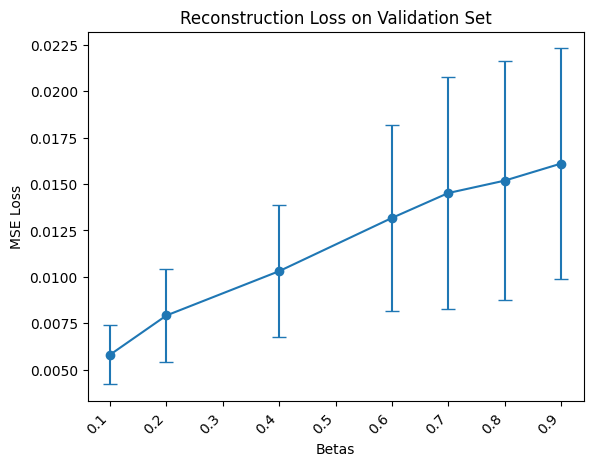

<Figure size 1000x600 with 0 Axes>

In [5]:
import matplotlib.cm as cm
test_accuracies = [{'avg_loss': 0.005803483368809519, 'std_loss': 0.0016035392455840346}, {'avg_loss': 0.007917284426510468, 'std_loss': 0.0024861534423623014}, {'avg_loss': 0.010304592486144352, 'std_loss': 0.003537493615517191}, {'avg_loss': 0.01317033116438635, 'std_loss': 0.005000988805252682}, {'avg_loss': 0.014512695175253774, 'std_loss': 0.006228974007260112}, {'avg_loss': 0.015180377257132645, 'std_loss': 0.00643375851366054}, {'avg_loss': 0.01609883228708529, 'std_loss': 0.006201845680511393}]
betas = [0.1, 0.2, 0.4 , 0.6, 0.7, 0.8, 0.9]
heights = [ i["avg_loss"] for i in test_accuracies]
labels = [f"beta = {i}" for i in betas]
error_bars = [i["std_loss"] for i in test_accuracies]
colors = cm.viridis(np.linspace(0, 1, len(labels)))
# plt.bar(labels, heights, yerr=error_bars, capsize=5, color=colors, edgecolor='black')
plt.errorbar(betas, heights, yerr=error_bars, 
             fmt='-o', capsize=5, label='Average Loss')
# 3. Optional: Add labels to make it readable
plt.xticks(rotation=45, ha='right')
plt.title('Reconstruction Loss on Validation Set')
plt.xlabel('Betas')
plt.ylabel('MSE Loss')

# 4. Display the chart
plt.show()

plt.figure(figsize=(10, 6))

# 3. Create the Error Bar Plot
# x: hyperparam_values
# y: avg_loss_values
# yerr: std_loss_values
# fmt='-o': This creates a line (-) with circular markers (o)
# capsize=5: This adds the horizontal 'caps' to the top and bottom of the error bars


# 4. Add labels and title

# 5. Show/Save the plot
plt.savefig('hyperparameter_plot.png')

## Tuned MLP VAE Evaluation

### Test Loss

In [3]:
src_dir = "/extra_storage/three_piece_assembly_latent_actions/buf.pkl"
n_test = 2 
n_val = 10
ac_chunk = 30
obs_dim = [9, 1]
ac_dim = [30, 10]
batch_size = 50
action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val, 
                                            mode="train",
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
val_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="val", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim)
test_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="test", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim) 

train_loader = DataLoader(action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10)
val_loader = DataLoader(val_action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10) 
test_loader = DataLoader(test_action_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers=10) 

model_type = "MLPVAE"
ac_chunk = 30
obs_dim = [9, 1]
ac_dim = [30, 10]
latent_dim = 150
hidden = [300, 300,300,300 ]
model = MLPVAE(obs_dim, ac_dim, latent_dim, hidden)
loss_fn = vae_loss
save_dir = "lr_sweep"
optim_params = {"log_freq": 100,
                "save_freq": 1000,
                "epochs": 100, 
                "lr": 0.001}

trainer = AE_Trainer(model, 
                         loss_fn, 
                         "cuda:0", 
                         optim_params, 
                         f"tuned_mlp_vae")
trainer.train_loop(train_loader, val_loader,1000)



Mode: train, Index list length: 188


100%|██████████| 188/188 [00:01<00:00, 131.73it/s]


Mode: val, Index list length: 10


100%|██████████| 10/10 [00:00<00:00, 172.05it/s]


Mode: test, Index list length: 2


100%|██████████| 2/2 [00:00<00:00, 148.41it/s]


Architecture of the model: 
 ModuleList(
  (0): Linear(in_features=309, out_features=300, bias=True)
  (1-3): 3 x ResidualBlock(
    (block): ModuleList(
      (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
      (2): GELU(approximate='none')
    )
    (in_proj): Linear(in_features=300, out_features=300, bias=True)
  )
  (4): Linear(in_features=300, out_features=150, bias=True)
)
Architecture of the model: 
 ModuleList(
  (0): Linear(in_features=159, out_features=300, bias=True)
  (1-3): 3 x ResidualBlock(
    (block): ModuleList(
      (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
      (2): GELU(approximate='none')
    )
    (in_proj): Linear(in_features=300, out_features=300, bias=True)
  )
  (4): Linear(in_features=300, out_features=309, bias=True)
)
{'log_freq': 100, 'save_freq': 1000, 'epochs': 100, 'lr': 0.001}
Starting training

Mode: test, Index list length: 200


100%|██████████| 200/200 [00:01<00:00, 112.58it/s]


Architecture of the model: 
 ModuleList(
  (0): Linear(in_features=309, out_features=300, bias=True)
  (1-6): 6 x ResidualBlock(
    (block): ModuleList(
      (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
      (2): GELU(approximate='none')
    )
    (in_proj): Linear(in_features=300, out_features=300, bias=True)
  )
  (7): Linear(in_features=300, out_features=150, bias=True)
)
Architecture of the model: 
 ModuleList(
  (0): Linear(in_features=159, out_features=300, bias=True)
  (1-6): 6 x ResidualBlock(
    (block): ModuleList(
      (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
      (2): GELU(approximate='none')
    )
    (in_proj): Linear(in_features=300, out_features=300, bias=True)
  )
  (7): Linear(in_features=300, out_features=309, bias=True)
)
Evaluation complete. Average Reconstruction Loss (MSE): 0.4549 (Std Dev: 4.3252)


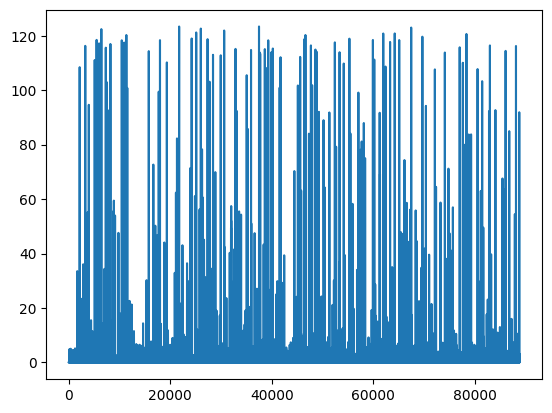

In [ ]:
import json
src_dir = "/extra_storage/equicontact_stacking_fixed_pose_sa/buf.pkl"
n_test = 1 
n_val = 10
ac_chunk = 30
obs_dim = [9, 1]
ac_dim = [30, 10]
batch_size = 50
test_action_dataset = LatentActionBuffer(src_dir, 
                                            n_test,
                                            n_val,
                                            mode="test", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim) 

test_loader = DataLoader(test_action_dataset, 
                                  batch_size = 1, 
                                  shuffle = False, 
                                  num_workers=10) 

model_type = "MLPVAE"
ac_chunk = 30
obs_dim = [9, 1]
ac_dim = [30, 10]
latent_dim = 150
hidden = [300, 300, 300, 300, 300, 300, 300]
model = MLPVAE(obs_dim, ac_dim, latent_dim, hidden)
state_dict = torch.load("/home/blank/cs282_project/latent_actions/mlp_vae_equicontact/checkpoint.pth")
model.load_state_dict(state_dict["model_state_dict"])
model.eval().cuda()
criterion = nn.MSELoss(reduction="sum")
test_losses = []
action_losses = []
counter = 0
with open("/extra_storage/equicontact_stacking_fixed_pose_sa/ac_norm.json", "r") as f: 
    norm = json.load(f)
    ac_mean = torch.Tensor(norm["action_norm"]["loc"]).to("cuda")
    ac_std = torch.Tensor(norm["action_norm"]["scale"]).to("cuda")
with torch.no_grad(): 
    for batch in test_loader: 
        states = batch[0]
        actions = batch[1].flatten(start_dim=1, end_dim=2) 

        states = states.to("cuda")
        actions = actions.to("cuda")
        gt_actions = (actions.reshape(ac_dim))
        gt_actions = (gt_actions * ac_std) + ac_mean
        gt = torch.cat([states, actions], dim=1)
        pred, mu,logvar = model(states, actions)
        pred_actions = pred[0, 9:].reshape(ac_dim)
        # print(pred.shape)
        pred_actions = pred_actions
        pred_actions = (pred_actions * ac_std) + ac_mean
        loss = criterion(pred, gt)
        loss2 = criterion(pred_actions, gt_actions)
        # print(f"Actions loss: {loss2}")
        test_losses.append(loss.item())
        action_losses.append(loss2.item())
        # if counter == 0:
        #     break
    losses = np.array(test_losses)
    action_losses = np.array(action_losses)
    avg_loss = losses.mean()
    std_loss = losses.std()
    action_avg_loss = action_losses.mean()
    action_std_loss = action_losses.std()

    # plt.plot(action_losses)
    # plt.show()
    print(f"Evaluation complete. Average Reconstruction Loss on Normalized Inputs, Outputs (MSE): {avg_loss:.4f} (Std Dev: {std_loss:.4f})")
    print(f"Evaluation complete. Average Reconstruction Loss on Actions (MSE): {action_avg_loss:.4f} (Std Dev: {action_std_loss:.4f})")

    


### t-SNE Visualization

In [13]:
from sklearn.manifold import TSNE
src_dir = "/extra_storage/threading_latent_actions/buf.pkl"
ac_chunk = 32
obs_dim = [9, 1]
ac_dim = [32, 10]
latent_dim = 150
test_action_dataset = LatentActionBuffer(src_dir, 
                                            1,
                                            10,
                                            mode="test", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim) 
test_loader = DataLoader(test_action_dataset, 
                                  batch_size = 1, 
                                  shuffle = False, 
                                  num_workers=1) 
# train_loader
model_type = "MLPVAE"
ac_chunk = 30
obs_dim = [9, 1]
ac_dim = [32, 10]
latent_dim = 75
hidden = [300, 300,300,300 ]
model = MLPVAE(obs_dim, ac_dim, latent_dim, hidden)
state_dict = torch.load("/home/blank/cs282_project/latent_actions/mlp_vae_threading/checkpoint.pth")
model.load_state_dict(state_dict["model_state_dict"])
model.eval().cuda()
criterion = nn.MSELoss()
all_latents = []
counter=0
with torch.no_grad(): 
    for batch in test_loader: 
        states = batch[0]
        actions = batch[1].flatten(start_dim=1, end_dim=2) 

        states = states.to("cuda")
        actions = actions.to("cuda")
        latents = model.enc(states, actions)
        # print(latents.detach().cpu().numpy().shape)
        all_latents.append(latents.detach().cpu().numpy().reshape((-1,)))
        counter+=1
latent_data = np.array(all_latents)


Mode: test, Index list length: 1


100%|██████████| 1/1 [00:00<00:00, 242.28it/s]

Architecture of the model: 
 ModuleList(
  (0): Linear(in_features=329, out_features=300, bias=True)
  (1-3): 3 x ResidualBlock(
    (block): ModuleList(
      (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
      (2): GELU(approximate='none')
    )
    (in_proj): Linear(in_features=300, out_features=300, bias=True)
  )
  (4): Linear(in_features=300, out_features=75, bias=True)
)
Architecture of the model: 
 ModuleList(
  (0): Linear(in_features=84, out_features=300, bias=True)
  (1-3): 3 x ResidualBlock(
    (block): ModuleList(
      (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
      (2): GELU(approximate='none')
    )
    (in_proj): Linear(in_features=300, out_features=300, bias=True)
  )
  (4): Linear(in_features=300, out_features=329, bias=True)
)


Architecture of the model: 
 ModuleList(
  (0): Linear(in_features=329, out_features=300, bias=True)
  (1-3): 3 x ResidualBlock(
    (block): ModuleList(
      (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
      (2): GELU(approximate='none')
    )
    (in_proj): Linear(in_features=300, out_features=300, bias=True)
  )
  (4): Linear(in_features=300, out_features=75, bias=True)
)
Architecture of the model: 
 ModuleList(
  (0): Linear(in_features=84, out_features=300, bias=True)
  (1-3): 3 x ResidualBlock(
    (block): ModuleList(
      (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
      (2): GELU(approximate='none')
    )
    (in_proj): Linear(in_features=300, out_features=300, bias=True)
  )
  (4): Linear(in_features=300, out_features=329, bias=True)
)
Latent Data Shape: (260, 75)
EEF Data Shape: (260, 3)
Running t-SNE...
[t-SNE] Compu

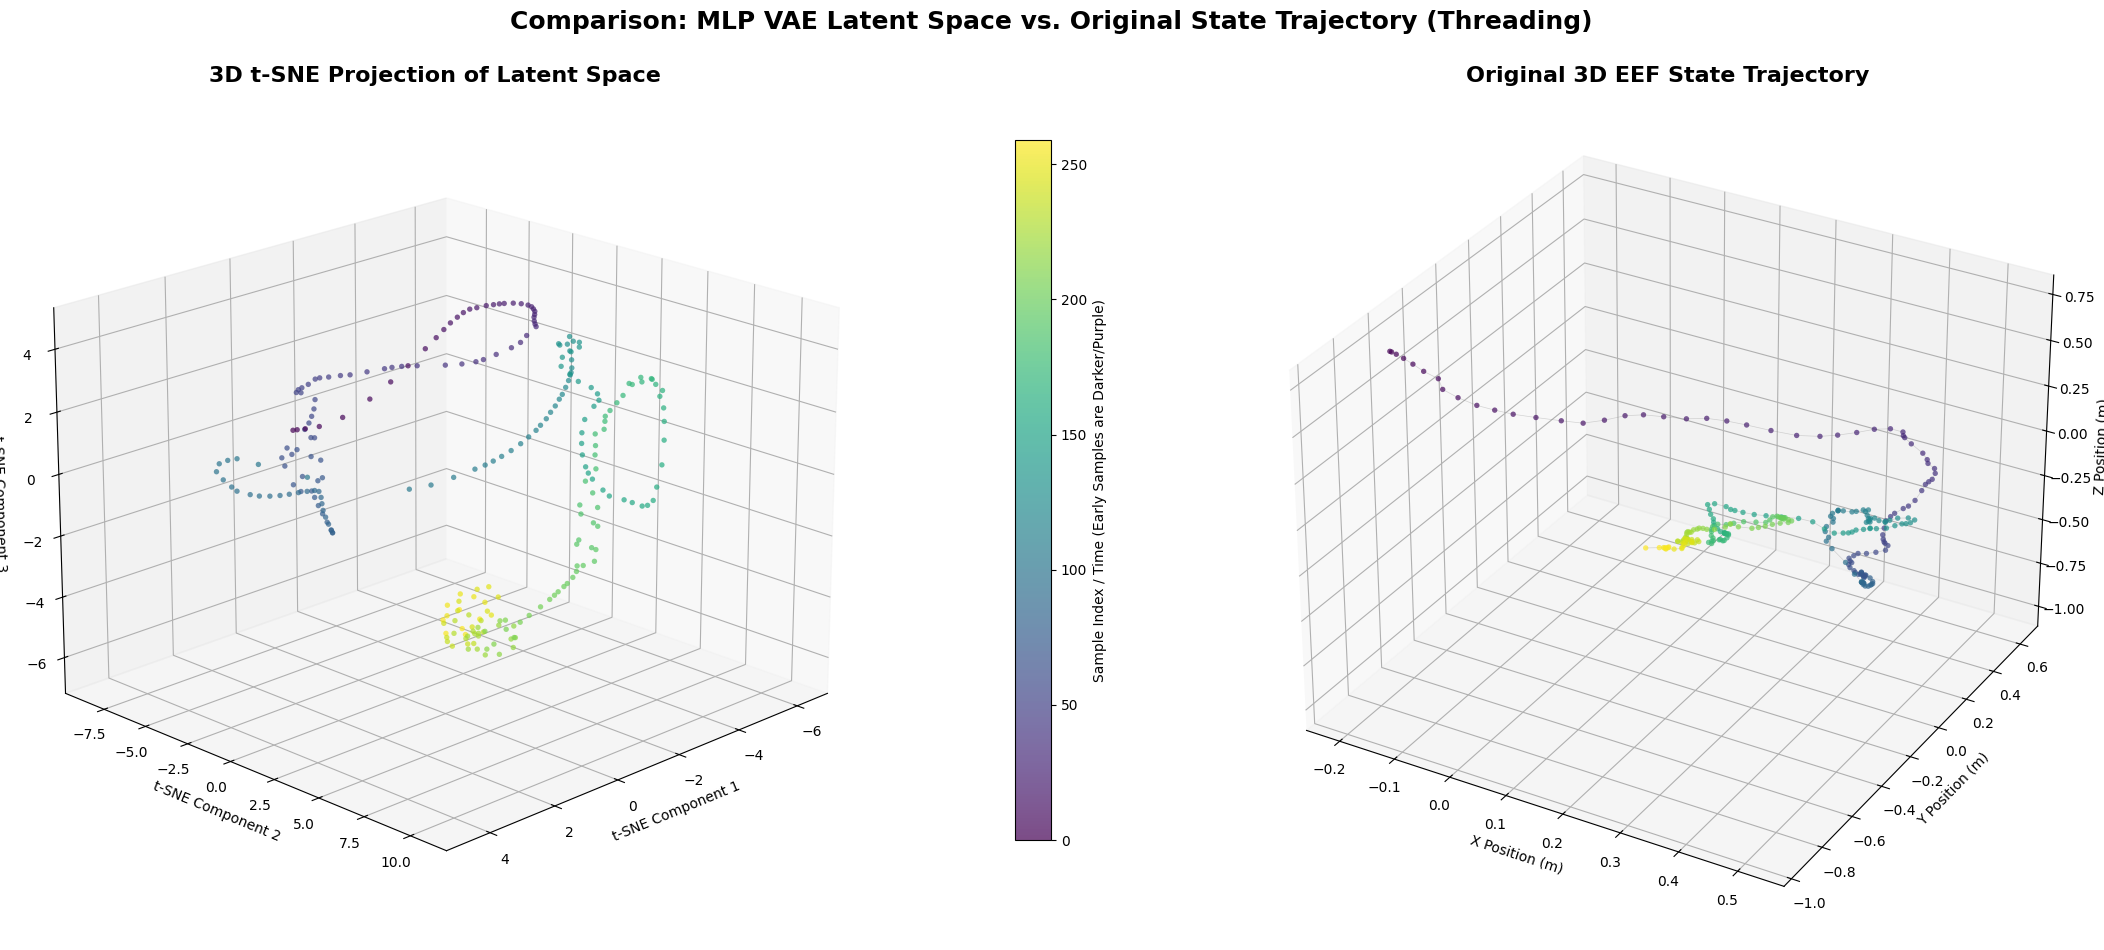

t-SNE and State Trajectory 3D visualizations displayed successfully with a fixed, centralized colorbar using dedicated axes.


In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import torch.nn as nn

# --- Assume Necessary Imports and Model/Data Setup ---
# NOTE: The LatentActionBuffer and MLPVAE classes are assumed to be available
# from the environment, as they are not defined here.

# --- Data Loading and VAE Inference (Modified to capture States) ---
# Assuming LatentActionBuffer, MLPVAE, and DataLoader are defined or imported.

# --- IMPORTANT ---
# To plot the original trajectory, we must save the 3D EEF position (first 3 elements of state)
# from the DataLoader batch.

src_dir = "/extra_storage/threading_latent_actions/buf.pkl"
ac_chunk = 32
obs_dim = [9, 1] # Assuming state is [3D Pos, Quat/6D Rot, Gripper]
ac_dim = [32, 10]
latent_dim = 75
hidden = [300, 300, 300, 300]
batch_size = 1 # Must remain 1 for sequential plotting

# Placeholder for classes not defined in the prompt:
# class LatentActionBuffer(torch.utils.data.Dataset): ...
# class MLPVAE(nn.Module): ...

# --- Load Model and Data ---
model = MLPVAE(obs_dim, ac_dim, latent_dim, hidden)
state_dict = torch.load("/home/blank/cs282_project/latent_actions/mlp_vae_threading/checkpoint.pth")
model.load_state_dict(state_dict["model_state_dict"])
model.eval().cuda()

# Assuming test_action_dataset is an instance of LatentActionBuffer
# test_action_dataset = LatentActionBuffer(src_dir, 1, 10, mode="test", obs_dim=obs_dim, ac_chunk=ac_chunk, ac_dim=ac_dim)
# test_loader = DataLoader(test_action_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

# --- START: Data Capture ---
all_latents = []
all_eef_pos = [] # <--- NEW: List to store EEF 3D positions
counter = 0

# NOTE: Since LatentActionBuffer and DataLoader are not defined, 
# I'll use a placeholder loop structure. Assume 'batch' yields (states, actions).
# Replicate the loop structure from your original code:
for batch in test_loader: 
    states = batch[0] # Shape (1, 9, 1) or similar if obs_dim=[9, 1]
    actions = batch[1].flatten(start_dim=1, end_dim=2) # Flattened chunk

    states = states.to("cuda").float()
    actions = actions.to("cuda").float()
    
    # Capture the EEF position (first 3 elements) from the CPU state tensor
    # NOTE: Assuming state layout is [EEF_X, EEF_Y, EEF_Z, ...]
    eef_pos_t = states[0, :3].detach().cpu().numpy() 
    all_eef_pos.append(eef_pos_t)

    # VAE Inference
    with torch.no_grad():
        latents = model.enc(states, actions)
        all_latents.append(latents.detach().cpu().numpy().reshape((-1,)))
    
    counter+=1
    # OPTIONAL: Limit the number of samples for faster t-SNE during debugging
    # if counter > 500: break

latent_data = np.array(all_latents)
eef_data = np.array(all_eef_pos) # Final shape (N, 3)
indices = np.arange(latent_data.shape[0])

print(f"Latent Data Shape: {latent_data.shape}")
print(f"EEF Data Shape: {eef_data.shape}")

# --- t-SNE Projection ---
tsne = TSNE(n_components=3, perplexity=30, random_state=42, n_jobs=-1, verbose=1)
print("Running t-SNE...")
tsne_results = tsne.fit_transform(latent_data) # Final shape (N, 3)

# --- START: Side-by-Side Plotting ---
fig = plt.figure(figsize=(24, 10)) 

# -----------------
# SUBPLOT 1: 3D t-SNE Latent Space
# Define subplot using figure grid, position 1
# -----------------
ax1 = fig.add_subplot(121, projection='3d') 

scatter = ax1.scatter(
    tsne_results[:, 0], 
    tsne_results[:, 1], 
    tsne_results[:, 2], 
    c=indices,  
    cmap='viridis', 
    s=15, 
    alpha=0.7,
    edgecolors='none'
)

# Titles and Axis Labels
ax1.set_title('3D t-SNE Projection of Latent Space', fontsize=16, fontweight='bold')
ax1.set_xlabel('t-SNE Component 1')
ax1.set_ylabel('t-SNE Component 2')
ax1.set_zlabel('t-SNE Component 3')
ax1.view_init(elev=20, azim=45)


# -----------------
# SUBPLOT 2: Original 3D EEF Trajectory
# Define subplot using figure grid, position 2
# -----------------
ax2 = fig.add_subplot(122, projection='3d') 

scatter_eef = ax2.scatter(
    eef_data[:, 0], 
    eef_data[:, 1], 
    eef_data[:, 2], 
    c=indices,  
    cmap='viridis', 
    s=15, 
    alpha=0.7,
    edgecolors='none'
)

ax2.plot(
    eef_data[:, 0], 
    eef_data[:, 1], 
    eef_data[:, 2], 
    color='gray', 
    alpha=0.3,
    linewidth=0.5
)


# Titles and Axis Labels
ax2.set_title('Original 3D EEF State Trajectory', fontsize=16, fontweight='bold')
ax2.set_xlabel('X Position (m)')
ax2.set_ylabel('Y Position (m)')
ax2.set_zlabel('Z Position (m)')


# -----------------
# CRITICAL FIX: Create a dedicated axis for the colorbar using [left, bottom, width, height]
# Coordinates are normalized (0 to 1) relative to the figure.
# Left: ~0.50 (middle)
# Width: 0.015 (thin colorbar)
# -----------------
cbar_ax = fig.add_axes([0.485, 0.15, 0.015, 0.7]) # [left, bottom, width, height]

# Ensure the color mapping is consistent for the colorbar
# Use the scatter_eef object to match the plotted data
cbar = fig.colorbar(
    scatter_eef, 
    cax=cbar_ax, # Use the new dedicated axis
    orientation='vertical'
)

cbar.set_label('Sample Index / Time (Early Samples are Darker/Purple)')


fig.suptitle(f'Comparison: MLP VAE Latent Space vs. Original State Trajectory (Threading)', 
             fontsize=18, fontweight='bold')

# Use subplots_adjust for overall plot padding
plt.subplots_adjust(
    left=0.02,     # Give more room on the left
    right=0.98,    # Give more room on the right
    bottom=0.05, 
    top=0.90, 
    wspace=0.15, 
    hspace=0.2
)
plt.show()

print("t-SNE and State Trajectory 3D visualizations displayed successfully with a fixed, centralized colorbar using dedicated axes.")

Mode: test, Index list length: 1


100%|██████████| 1/1 [00:00<00:00, 200.54it/s]

Architecture of the model: 
 ModuleList(
  (0): Linear(in_features=329, out_features=300, bias=True)
  (1-3): 3 x ResidualBlock(
    (block): ModuleList(
      (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
      (2): GELU(approximate='none')
    )
    (in_proj): Linear(in_features=300, out_features=300, bias=True)
  )
  (4): Linear(in_features=300, out_features=75, bias=True)
)
Architecture of the model: 
 ModuleList(
  (0): Linear(in_features=84, out_features=300, bias=True)
  (1-3): 3 x ResidualBlock(
    (block): ModuleList(
      (0): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=300, out_features=300, bias=True)
      (2): GELU(approximate='none')
    )
    (in_proj): Linear(in_features=300, out_features=300, bias=True)
  )
  (4): Linear(in_features=300, out_features=329, bias=True)
)


Running t-SNE on 1920 samples...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1920 samples in 0.000s...
[t-SNE] Computed neighbors for 1920 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1920
[t-SNE] Computed conditional probabilities for sample 1920 / 1920
[t-SNE] Mean sigma: 0.632348
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.917236
[t-SNE] KL divergence after 1000 iterations: 0.175331


/tmp/ipykernel_285772/1322975487.py:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_noisy = get_cmap('Set1', NUM_NOISY_SAMPLES)


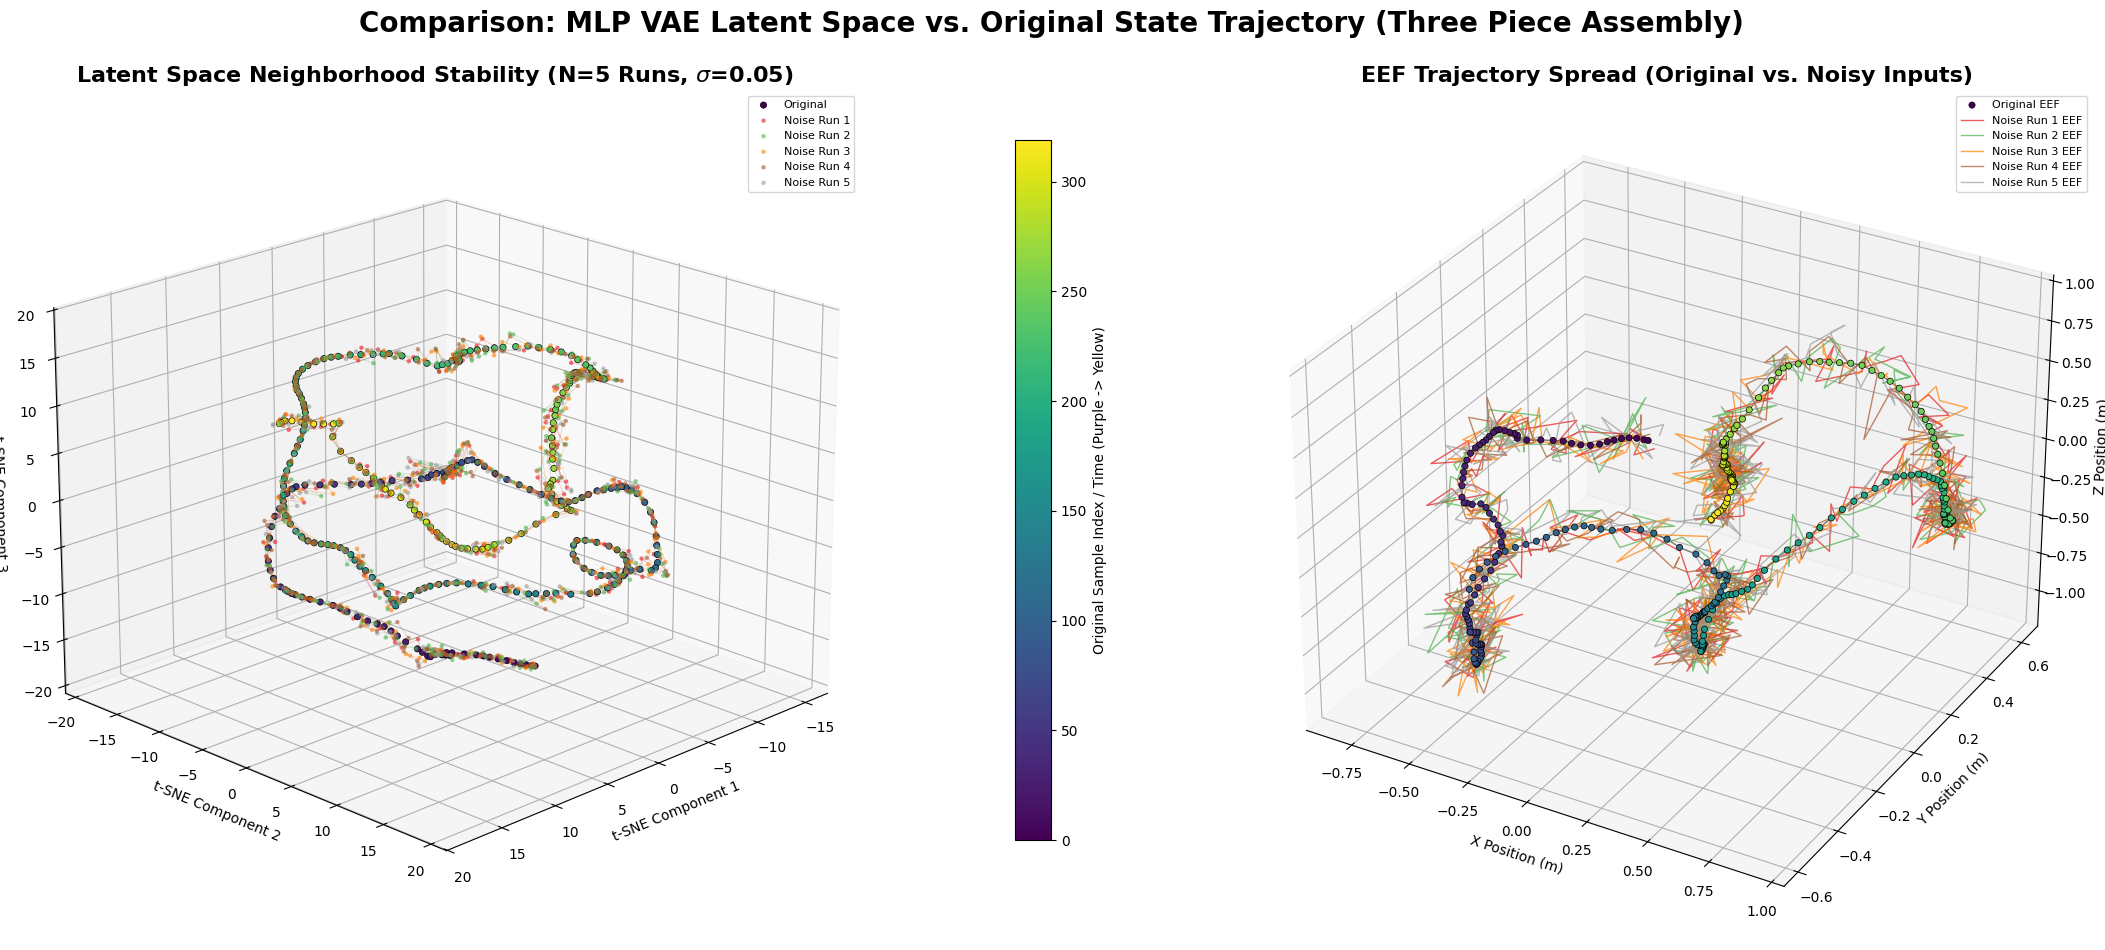

In [47]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import torch.nn as nn
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap

# --- Configuration ---
src_dir = "/extra_storage/three_piece_assembly_latent_actions/buf.pkl"
ac_chunk = 32
obs_dim = [9, 1]
ac_dim = [32, 10]
latent_dim = 75
hidden = [300, 300, 300, 300]

batch_size = 1 
NOISE_STD = 0.05 # Standard deviation for Gaussian noise applied to state components
NUM_NOISY_SAMPLES = 5 # <--- NEW: Number of noisy trajectories to generate

test_action_dataset = LatentActionBuffer(src_dir, 
                                            1,
                                            10,
                                            mode="test", 
                                            obs_dim=obs_dim, 
                                            ac_chunk = ac_chunk, 
                                            ac_dim = ac_dim) 
test_loader = DataLoader(test_action_dataset, 
                                  batch_size = 1, 
                                  shuffle = False, 
                                  num_workers=1) 
# --- Load Model and Data ---
# Assuming LatentActionBuffer, MLPVAE, and DataLoader are defined and ready

model = MLPVAE(obs_dim, ac_dim, latent_dim, hidden)
state_dict = torch.load("/home/blank/cs282_project/latent_actions/mlp_vae_stacking/checkpoint.pth")
model.load_state_dict(state_dict["model_state_dict"])
model.eval().cuda()

# --- START: Data Capture for Original and Multiple Noisy Samples ---
all_latents_orig = []
all_eef_pos_orig = []
all_latents_multi_noisy = [] # Stores list of arrays for N noisy runs
all_eef_pos_multi_noisy = [] # Stores list of arrays for N noisy runs

counter = 0
for batch in test_loader: 
    states = batch[0] # Original states (e.g., [1, 9, 1])
    actions = batch[1].flatten(start_dim=1, end_dim=2) 

    # Prepare tensors for VAE inference
    states_orig = states.to("cuda").float()
    actions = actions.to("cuda").float()
    
    # Capture Original EEF position
    eef_pos_orig = states[0, :3].detach().cpu().numpy() 
    all_eef_pos_orig.append(eef_pos_orig)

    # VAE Inference for Original Latents
    with torch.no_grad():
        latents_orig = model.enc(states_orig, actions)
        all_latents_orig.append(latents_orig.detach().cpu().numpy().reshape((-1,)))
    
    # --- Generate Multiple Noisy Samples ---
    noisy_latents_i = []
    noisy_eef_pos_i = []
    
    for _ in range(NUM_NOISY_SAMPLES):
        # Create Gaussian noise tensor: shape (1, 9, 1)
        noise = torch.randn_like(states) * NOISE_STD 
        states_noisy_cpu = states + noise
        
        # Capture Noisy EEF position
        eef_pos_noisy = states_noisy_cpu[0, :3].detach().cpu().numpy()
        noisy_eef_pos_i.append(eef_pos_noisy)

        # VAE Inference for Noisy Latents
        states_noisy = states_noisy_cpu.to("cuda").float()
        with torch.no_grad():
            latents_noisy = model.enc(states_noisy, actions)
            noisy_latents_i.append(latents_noisy.detach().cpu().numpy().reshape((-1,)))
    
    all_latents_multi_noisy.append(np.array(noisy_latents_i))
    all_eef_pos_multi_noisy.append(np.array(noisy_eef_pos_i))

    counter+=1
    # OPTIONAL: Limit the number of samples for faster t-SNE during debugging
    # if counter > 1000: break 

# --- Prepare Data for Plotting ---
latent_data_orig = np.array(all_latents_orig)
eef_data_orig = np.array(all_eef_pos_orig)

# The shape of these arrays is now (N_samples, N_runs, Latent_Dim/3)
latent_data_multi_noisy = np.array(all_latents_multi_noisy)
eef_data_multi_noisy = np.array(all_eef_pos_multi_noisy)

indices = np.arange(latent_data_orig.shape[0])
N_samples = latent_data_orig.shape[0]

# --- t-SNE Projection (Run on ALL data together) ---
# Concatenate original (N) + all noisy data (N * NUM_NOISY_SAMPLES)
latent_data_flat_noisy = latent_data_multi_noisy.reshape(-1, latent_dim)
combined_latent_data = np.concatenate([latent_data_orig, latent_data_flat_noisy], axis=0)

tsne = TSNE(n_components=3, perplexity=30, random_state=42, n_jobs=-1, verbose=1)
print(f"Running t-SNE on {combined_latent_data.shape[0]} samples...")
tsne_results_combined = tsne.fit_transform(combined_latent_data) 

# Split results back into original and noisy sets
tsne_orig = tsne_results_combined[:N_samples]
tsne_noisy_flat = tsne_results_combined[N_samples:]
tsne_noisy_multi = tsne_noisy_flat.reshape(N_samples, NUM_NOISY_SAMPLES, 3) # (N_samples, N_runs, 3)

# --- START: 1x2 Plotting with Overlay ---
fig = plt.figure(figsize=(24, 10)) 

# Define a color map for the noisy runs
cmap_noisy = get_cmap('Set1', NUM_NOISY_SAMPLES)

# -----------------
# SUBPLOT 1: 3D t-SNE Latent Space (Overlay)
# -----------------
ax1 = fig.add_subplot(121, projection='3d')

# 1. Plot Original Trajectory (Colored by Time/Index)
scatter_orig_latent = ax1.scatter(
    tsne_orig[:, 0], tsne_orig[:, 1], tsne_orig[:, 2], 
    c=indices, cmap='viridis', s=20, alpha=1.0, edgecolors='k', linewidths=0.5, label='Original'
)

# 2. Plot Noisy Trajectories (Each run gets a different color)
for i in range(NUM_NOISY_SAMPLES):
    # Scatter the points
    ax1.scatter(
        tsne_noisy_multi[:, i, 0], 
        tsne_noisy_multi[:, i, 1], 
        tsne_noisy_multi[:, i, 2], 
        color=cmap_noisy(i), 
        s=10, 
        alpha=0.6, 
        edgecolors='none', 
        label=f'Noise Run {i+1}'
    )
    # Optionally connect points to show the path of the noisy run
    ax1.plot(
        tsne_noisy_multi[:, i, 0], 
        tsne_noisy_multi[:, i, 1], 
        tsne_noisy_multi[:, i, 2], 
        color=cmap_noisy(i), 
        alpha=0.3,
        linewidth=0.5
    )

# Titles and Axis Labels
ax1.set_title(f'Latent Space Neighborhood Stability (N={NUM_NOISY_SAMPLES} Runs, $\sigma$={NOISE_STD})', fontsize=16, fontweight='bold')
ax1.set_xlabel('t-SNE Component 1')
ax1.set_ylabel('t-SNE Component 2')
ax1.set_zlabel('t-SNE Component 3')
ax1.view_init(elev=20, azim=45)
ax1.legend(loc='best', fontsize=8)


# -----------------
# SUBPLOT 2: Original 3D EEF Trajectory (Overlay)
# -----------------
ax2 = fig.add_subplot(122, projection='3d')

# 1. Plot Original EEF Trajectory (Colored by Time/Index)
scatter_orig_eef = ax2.scatter(
    eef_data_orig[:, 0], eef_data_orig[:, 1], eef_data_orig[:, 2], 
    c=indices, cmap='viridis', s=20, alpha=1.0, edgecolors='k', linewidths=0.5, label='Original EEF'
)
ax2.plot(eef_data_orig[:, 0], eef_data_orig[:, 1], eef_data_orig[:, 2], 
         color='k', alpha=0.5, linewidth=1.0) # Black line for original

# 2. Plot Noisy EEF Trajectories (Each run gets a different color)
for i in range(NUM_NOISY_SAMPLES):
    # Plot the line trajectory
    ax2.plot(
        eef_data_multi_noisy[:, i, 0], 
        eef_data_multi_noisy[:, i, 1], 
        eef_data_multi_noisy[:, i, 2], 
        color=cmap_noisy(i), 
        alpha=0.7,
        linewidth=1.0,
        label=f'Noise Run {i+1} EEF' # Only label one
    )
    # Scatter points are less necessary here as the line shows the path clearly

# Titles and Axis Labels
ax2.set_title('EEF Trajectory Spread (Original vs. Noisy Inputs)', fontsize=16, fontweight='bold')
ax2.set_xlabel('X Position (m)')
ax2.set_ylabel('Y Position (m)')
ax2.set_zlabel('Z Position (m)')
ax2.legend(loc='best', fontsize=8)


# --- Central Colorbar (For Original Trajectory Time Index) ---
cbar_ax = fig.add_axes([0.485, 0.15, 0.015, 0.7]) # [left, bottom, width, height]
cbar = fig.colorbar(scatter_orig_latent, cax=cbar_ax, orientation='vertical')
cbar.set_label('Original Sample Index / Time (Purple -> Yellow)')

fig.suptitle(f'Comparison: MLP VAE Latent Space vs. Original State Trajectory (Three Piece Assembly)', 
             fontsize=20, fontweight='bold')

plt.subplots_adjust(
    left=0.02, 
    right=0.98,
    bottom=0.05, 
    top=0.90, 
    wspace=0.15, 
    hspace=0.2
)
plt.show()
# print(f"2x2 visualization displayed showing original and noisy data. Noise applied to state components: $\sigma={NOISE\_STD}$")

Latent Data Shape: (260, 75)
Running t-SNE...


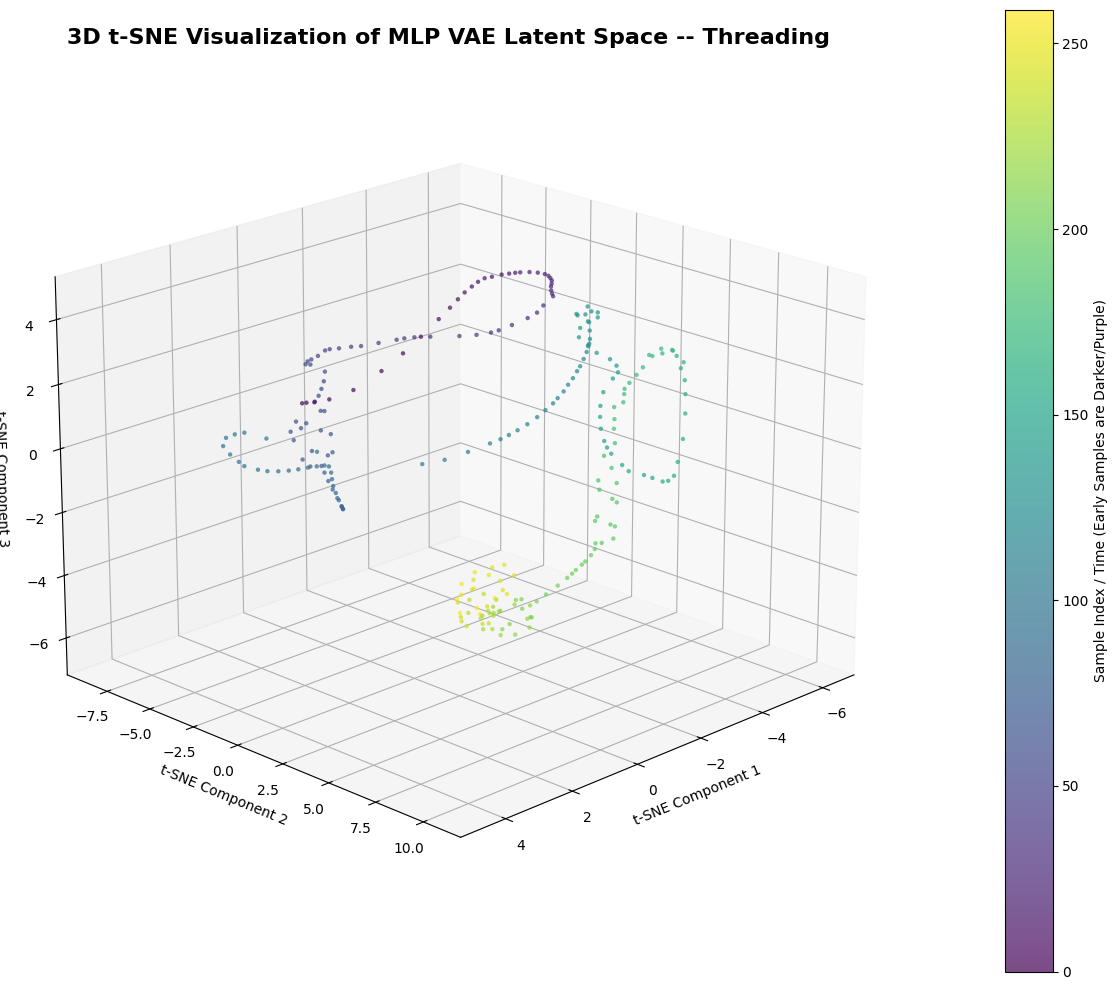

t-SNE 3D visualization displayed successfully.


In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
from sklearn.manifold import TSNE
import numpy as np

# Assuming latent_data is defined
print(f"Latent Data Shape: {latent_data.shape}")

# 1. Change n_components to 3
tsne = TSNE(n_components=3, perplexity=30, random_state=42, n_jobs=-1)

# Fit and transform the data
print("Running t-SNE...")
tsne_results = tsne.fit_transform(latent_data)
indices = np.arange(tsne_results.shape[0])

# Plotting the results
fig = plt.figure(figsize=(12, 10))

# 2. Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# 3. Scatter plot with x, y, AND z coordinates
# Note: I changed 'c' to 'indices' so the colorbar logic (Time/Index) is actually true.
scatter = ax.scatter(
    tsne_results[:, 0], 
    tsne_results[:, 1], 
    tsne_results[:, 2], 
    c=indices,  # Using indices so gradient represents time/sequence
    cmap='viridis', 
    s=10, 
    alpha=0.7,
    edgecolors='none'
)

# Colorbar setup
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Sample Index / Time (Early Samples are Darker/Purple)')

# Titles and Axis Labels
ax.set_title('3D t-SNE Visualization of MLP VAE Latent Space -- Threading', fontsize=16, fontweight='bold')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

# Optional: Change initial viewing angle (elevation, azimuth)
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()
print("t-SNE 3D visualization displayed successfully.")